In [16]:
import pandas as pd
import numpy as np

## we set the root path for this code and the subdirectories are codes, pure_data, ...
_path= '/home/maximus/Documents/bcb/svca/code/adamOptimizer2/structured/'
_sample_name = 'P1_SAy10x1_G1'
## loading expressions and positions and protein names

def loading_pure_data(path=_path, sample_name=_sample_name ):
    exp_path = path+ 'pure_data/' + sample_name
    expressions = pd.read_csv(exp_path + '/expressions.txt',sep=" ")
    posit = pd.read_csv(exp_path + '/positions.txt', sep=",", header=None)
    protein_names = list(expressions.columns)


    return np.array(expressions), np.array(posit), protein_names
  
## loading all outputs of svca model
## for now we just load for each protein 4 number as 4 gower multiplier

def loading_results_of_svca(protein_names, path=_path, sample_name='P1_SAy10x1_G1'):
    
    results_path = path + 'pure_data/'+ sample_name + '/results/'
    signatures = []
    ## r=root, d=directories, f = files
    files = []
    for r, d, f in os.walk(results_path):
        for file in f:
            if '.txt' in file:
                files.append(os.path.join(r, file))


    svca_signs = []
    for i in range(len(prot_names)):
        file = pd.read_csv(results_path + prot_names[i]+ '_0_interactions_effects.txt',sep=" ")
        svca_signs.append(file.values[0].tolist())

    return svca_signs


NameError: name 'loading_pure_data' is not defined

In [5]:
from loader import *

a , b, c = loading_pure_data()


In [10]:
b.shape

(690, 2)

In [5]:
expressions = a
y1 = expressions['CD20'].values


In [1]:
import numpy as np
from utils import *
from loader import *

def preprocessing_data(path, sample_name):
    expressions, possitions, protein_names = loading_pure_data(path=path, sample_name=sample_name)

    proteins_number = len(protein_names)
    # np.delete(np.array(expressions), 5, axis=1)

    z_sample = expressions[:, 0]
    y_sample = quantile_normalise_phenotype(z_sample)
    y_sample = y_sample.reshape((y_sample.shape[0], 1))

    x_sample = np.delete(expressions, 0, axis=1)

    all_x = np.zeros((x_sample.shape[0], x_sample.shape[1]))
    all_y = np.zeros((y_sample.shape[0], y_sample.shape[1]))

    for i in range(len(protein_names)):

        z_sample = expressions[:, i]
        y_sample = quantile_normalise_phenotype(z_sample)
        y_sample = y_sample.reshape((y_sample.shape[0], 1))

        x_sample = np.delete(expressions, i, axis=1)

        all_y = np.append(all_y, y_sample, axis=0)
        all_x = np.append(all_x, x_sample, axis=0)

    all_x = all_x.reshape((proteins_number +1,x_sample.shape[0], x_sample.shape[1]))[1:, :, :]
    all_y = all_y.reshape((proteins_number +1,y_sample.shape[0], y_sample.shape[1]))[1:, :, :]

    return all_x, all_y

In [13]:
from preparing_data import *
_path= '/home/maximus/Documents/bcb/svca/code/adamOptimizer2/structured/'
_sample_name = 'P1_SAy10x1_G1'

all_x, all_y =preprocessing_data(path=_path, sample_name=_sample_name)

In [4]:
y.shape

(26, 690, 1)

In [2]:
import numpy as np
import tensorflow as tf
from utils import *
from preparing_data import * 
from loader import *

ix = tf.placeholder(shape=[None, None], dtype=tf.float64, name="x")
y = tf.placeholder(shape=[None, 1], dtype=tf.float64, name="y")
possition = tf.placeholder(shape=[None,None], dtype=tf.float64, name="position")


# randoms = tf.random_uniform([5], minval=0, maxval=100, dtype=tf.float64)
randoms = [1., 1., 1., 1., 20.]
sig1 = tf.Variable(randoms[0], dtype=tf.float64, name="sig1")
sig2 = tf.Variable(randoms[1], dtype=tf.float64, name="sig2")
sig3 = tf.Variable(randoms[2], dtype=tf.float64, name="sig3")
sig4 = tf.Variable(randoms[3], dtype=tf.float64, name="sig4")

lr = tf.placeholder(shape=[], dtype=tf.float64, name='lr')

### cov_matrix1 sigma* matrix      xxxxxxxxxxxxxxxxxxxxxx
x = ix - tf.reduce_mean(ix,0)
xxt = tf.matmul(x, tf.transpose(x))
sig1_pow2 = tf.pow(sig1, 2)

cov_matrix1 = sig1_pow2 * xxt

### cov_matrix2 sigma* matrix
def env_pos(x):
    return tf.exp(((-1)*(0.5)*x)/(tf.pow(l,2)))

l = tf.Variable(randoms[4], dtype=tf.float64, name="l")
zzt = tf.map_fn(env_pos, possition)
sig2_pow2 = tf.pow(sig2, 2)
cov_matrix2 = sig2_pow2 * zzt 

### cov_matrix3 sigma* matrix
u = tf.ones_like(xxt)
v = tf.eye(tf.shape(xxt)[0])
# num_of_cells = 690
# n = tf.constant(num_of_cells, dtype=tf.float64)
mask = tf.cast(u, dtype=tf.float64) - tf.cast(v, dtype=tf.float64)
weight = tf.math.multiply(mask, zzt)
zx = tf.matmul(weight, x)
old_zxxzt = tf.matmul(zx, tf.transpose(zx))
zxxzt = old_zxxzt
sig3_pow2 = tf.pow(sig3, 2)
cov_matrix3 = sig3_pow2 * zxxzt 

### cov_matrix4 sigma* matrix
noise__ = tf.eye(tf.shape(xxt)[0])
noise = tf.cast(noise__, dtype=tf.float64)
sig4_pow2 = tf.pow(sig4, 2)
cov_matrix4 = sig4_pow2 * noise

###### main covariance matrix
cov_matrix = cov_matrix1 + cov_matrix2 + cov_matrix3 + cov_matrix4

##### log likelihood term1
# cov_det = tf.linalg.det(cov_matrix)
cov_inv = tf.linalg.inv(cov_matrix)
loss_term1 = tf.matmul(tf.matmul(tf.transpose(y), cov_inv), y)

##### log likelihood term2
primary_loss_term2 = tf.linalg.slogdet(cov_matrix)
loss_term2 = primary_loss_term2[0]* primary_loss_term2[1]

#### loss function :log likelihood without constant vairable n/2log(pi)
loglikelihood = tf.add(loss_term1, loss_term2)
loss = 0.5*loglikelihood

### optimizer
optimizer = tf.train.AdamOptimizer(learning_rate= lr).minimize(loss)

In [3]:
# _path= '/home/maximus/Documents/bcb/svca/code/adamOptimizer2/structured/'
# _sample_name = 'P1_SAy10x1_G1'

# _, locations, protein_names = loading_pure_data(path=_path, sample_name=_sample_name)
# pos1 = distance_matrix(locations)
# sess = tf.Session()

# sess.run(tf.global_variables_initializer())
# j=0
# print()
# # a,b,c,d, = sess.run([sig1, sig2, sig3, sig4], feed_dict= {ix:all_x[j], y:all_y[j], possition: pos1})
# # a, b, c, d, lt, opt, run_loss,  = sess.run([sig1, sig2, sig3, sig4,l, optimizer, loss],feed_dict= {ix:all_x[j], y:all_y[j], possition: dist, lr:learning_rate})
            
# print((a,b,c,d))
# # print(np.sum(zzt))
# # print(np.max(np.abs(out - xxt)))

In [4]:
####### Main ##############################
from preparing_data import *
import time

_path= '/home/maximus/Documents/bcb/svca/code/adamOptimizer2/structured/'
_sample_name = 'P1_SAy10x1_G1'

_, locations, protein_names = loading_pure_data(path=_path, sample_name=_sample_name)
dist = distance_matrix(locations)
all_x, all_y =preprocessing_data(path=_path, sample_name=_sample_name)

loss_for_multiple_random_input = []
opt_loss_for_multiple_random_input = []
sigmas_for_multiple_random_input = []
opt_sigmas_for_multiple_random_input = []
selected_proteins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,25]

### initial values are not important yet so i do not save theme


epochs = 400
replicates = 1

with tf.Session() as sess:
    for replica in range(replicates):
        loss_for_selected_proteins = []
        opt_loss_for_selected_proteins = []
        sigmas_for_selected_proteins = []
        opt_sigmas_selected_proteins = []

        threshold = 0.1
        learning_rate=0.1
        learning_rate_1 = 0.1
        learning_rate_2 = 1.5

        for j in selected_proteins:
            loss_for_one_protein = []
            sigmas_for_one_protein = []
            sess.run(tf.global_variables_initializer())
            i = 0
            s1_opt, s2_opt, s3_opt, s4_opt, l_opt, a, b, c, d, lt = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
            min_loss_ever, last_loss, new_loss = np.inf, -np.inf, np.inf
            t0 = time.time()
            random_values = []
            print(j, ': ')

            while( (i < epochs) and (abs(last_loss-new_loss)>threshold) and ( last_loss==np.inf or min_loss_ever== np.inf or last_loss==min_loss_ever or ((last_loss-min_loss_ever)/abs(min_loss_ever) < 0.6) )):
#             while( (i < epochs) and (abs(last_loss-new_loss)>threshold)):
                a, b, c, d, lt, opt, run_loss, = sess.run(
                    [sig1, sig2, sig3, sig4,l, optimizer, loss],
                    feed_dict= {ix:all_x[j], y:all_y[j], possition: dist, lr:learning_rate})
            

                run_loss = run_loss[0]
                i += 1
                last_loss = new_loss
                new_loss = run_loss
                
                loss_for_one_protein.append(run_loss)
                sigmas_for_one_protein.append([a, b, c, d, lt])
                
                if min_loss_ever > run_loss:
                    min_loss_ever = run_loss
                    s1_opt, s2_opt, s3_opt, s4_opt, l_opt = (a, b, c, d, lt)
#                         cm1_opt, cm2_opt, cm3_opt, cm4_opt = (cm1, cm2, cm3, cm4)
                if run_loss > 1500:
                    learning_rate = learning_rate_2
                else:
                    learning_rate = learning_rate_1
                print('loss: ', run_loss)
            
            opt_sigmas_one_protein = [s1_opt, s2_opt, s3_opt, s4_opt, l_opt]
            opt_loss_for_one_protein = min_loss_ever
            
            loss_for_selected_proteins.append(loss_for_one_protein)
            opt_loss_for_selected_proteins.append(opt_loss_for_one_protein)
            sigmas_for_selected_proteins.append(sigmas_for_one_protein)
            opt_sigmas_selected_proteins.append(opt_sigmas_one_protein)
            
            t1 = time.time()
            print(i)
            

            # loading opt conds!
#             sess.run([tf.assign(sig1, s1_opt), tf.assign(sig2, s2_opt), tf.assign(sig3, s3_opt), tf.assign(sig4, s4_opt), tf.assign(l, l_opt)])

#             print("sig1 is: ", s1_opt, "sig2 is: ", s2_opt, "sig3 is: ", s3_opt, "sig4 is: ", s4_opt, "The L is: ", l_opt, "Loss is: ", min_loss_ever)
#             print("sig1 is: ", gowers[-1][0], "sig2 is: ", gowers[-1][1], "sig3 is: ", gowers[-1][2], "sig4 is: ", gowers[-1][3], "The L is: ", l_opt, "Loss is: ", min_loss_ever)
#             print("time of calculation for ***",prot_names[j],"*** is: " ,t1-t0)
#             print("--------------------------------------")
        loss_for_multiple_random_input.append(    loss_for_selected_proteins)
        opt_loss_for_multiple_random_input.append(opt_loss_for_selected_proteins)
        sigmas_for_multiple_random_input.append(    sigmas_for_selected_proteins)
        opt_sigmas_for_multiple_random_input.append(opt_sigmas_selected_proteins)
        
#         loss_for_100_random_input.append(prot_loss)
#         signature_for_100_random_input.append(signatures)
#         epochs_for_100_random_input.append(epochs_list)
#         print(epochs_for_100_random_input[-1])

0 : 
loss:  [353.18837214]
loss:  [310.00712551]
loss:  [270.26013106]
loss:  [239.00954208]
loss:  [225.3080624]
loss:  [233.68327804]
loss:  [234.58048367]
loss:  [215.33179028]
loss:  [191.30720595]
loss:  [179.46592617]
loss:  [188.08207695]
loss:  [180.24393369]
loss:  [187.48303129]
loss:  [194.63123821]
loss:  [199.07269152]
loss:  [200.41705793]
loss:  [199.20172266]
loss:  [196.40049552]
loss:  [193.1989485]
loss:  [190.77582785]
loss:  [189.93624303]
loss:  [190.61557036]
loss:  [191.69422761]
loss:  [191.74376399]
24
1 : 
loss:  [392.19846919]
loss:  [358.25653535]
loss:  [331.49066721]
loss:  [318.02605307]
loss:  [317.654794]
loss:  [311.4177273]
loss:  [297.17067495]
loss:  [281.19683976]
loss:  [267.23813033]
loss:  [258.31632283]
loss:  [267.75246641]
loss:  [268.27338317]
loss:  [273.05754251]
loss:  [274.50827947]
loss:  [275.1619128]
loss:  [274.5787978]
loss:  [273.04483699]
loss:  [271.41730555]
loss:  [270.62793342]
loss:  [271.08443264]
loss:  [272.08595529]
loss

loss:  [264.78832561]
loss:  [265.82893292]
loss:  [266.59018455]
loss:  [266.80694143]
loss:  [266.56174387]
loss:  [265.95097233]
loss:  [265.11763249]
loss:  [264.51319987]
loss:  [265.1502508]
loss:  [265.41562279]
loss:  [264.34746285]
loss:  [264.59501268]
loss:  [265.07966517]
loss:  [265.16114416]
60
12 : 
loss:  [342.96827279]
loss:  [297.86452832]
loss:  [255.42268878]
loss:  [220.24925134]
loss:  [200.92722697]
loss:  [204.1159558]
loss:  [204.55663122]
loss:  [187.31018876]
loss:  [163.3832336]
loss:  [146.34145286]
loss:  [171.46420819]
loss:  [146.61475403]
loss:  [153.0643086]
loss:  [162.11555562]
loss:  [168.85335632]
loss:  [172.23324031]
loss:  [172.48823309]
loss:  [170.42017605]
loss:  [167.16043268]
loss:  [164.03620061]
loss:  [162.34891353]
loss:  [162.90040444]
loss:  [165.29340614]
loss:  [167.66772655]
loss:  [167.89312302]
loss:  [165.49128189]
loss:  [161.88139258]
loss:  [158.86377093]
loss:  [157.36577966]
loss:  [157.282237]
30
13 : 
loss:  [295.65315841

loss:  [235.6804543]
loss:  [225.894493]
loss:  [205.4470243]
loss:  [186.08839881]
loss:  [175.76332167]
loss:  [172.81834384]
loss:  [170.65629608]
loss:  [180.93377993]
loss:  [189.21441287]
loss:  [194.52640581]
loss:  [196.9416055]
loss:  [197.03629991]
17


In [17]:
import os

_path = '../../../svca/SVCA/examples/IMC_one_example/P1_SAy10x1_G1/results/'
def loading_losses_of_svca(protein_names, path=_path):

    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if '.txt' in file:
                files.append(os.path.join(r, file))

    their_loss = []
    for i in selected_proteins:

        file = pd.read_csv(path + protein_names[i]+ '_0_interactions_lmls.txt',sep=" ", header= None)
        their_loss.append(file.values[0][0])
    return their_loss

In [22]:
gg = np.array((opt_loss_for_multiple_random_input))
gg = opt_loss_for_multiple_random_input[0]

In [23]:
!ls

'comparing the losses of SVCA and Tensorflow moadel.png'   preparing_data.py
 loader.ipynb						   __pycache__
 loader.py						   utils.py
 main.py


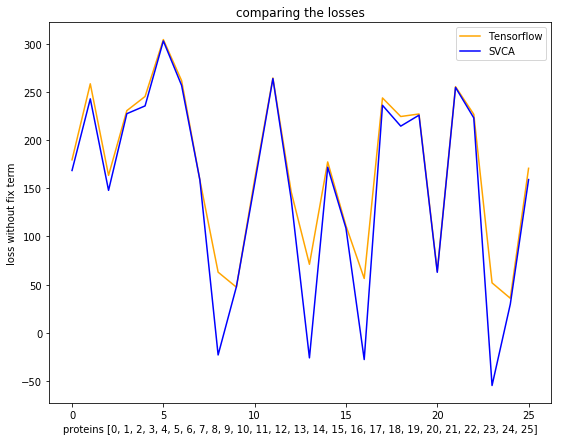

In [24]:
import matplotlib.pyplot as plt
import numpy as np
def comparing_losses(svca_losses, tensorflow_loss, selected_proteins):
    plt.figure(figsize=(9,7))
    plt.plot(selected_proteins, tensorflow_loss ,c='orange', label= "Tensorflow")
    plt.plot(selected_proteins, svca_losses,c='blue', label= "SVCA")
    plt.legend(loc='upper right')
    plt.xlabel("proteins "+ str(selected_proteins))
    plt.ylabel("loss without fix term")
    plt.title("comparing the losses")
    plt.savefig('../results/comparison/comparing the losses of SVCA and Tensorflow model.png', dpi= 500)
    plt.show()
comparing_losses(their_loss, gg, selected_proteins)

In [33]:
hh = np.array(loss_for_multiple_random_input)
# hh = hh.tolist()

In [40]:
def convertSigmasToGower(sigmas, )

[array([392.19846919]),
 array([388.61174063]),
 array([385.06007433]),
 array([381.54702498]),
 array([378.0763428]),
 array([374.65203906]),
 array([371.27834294]),
 array([367.95968614]),
 array([364.70072824]),
 array([361.50632358]),
 array([358.38149223]),
 array([355.33141202]),
 array([352.36136825]),
 array([349.47669688]),
 array([346.68273564]),
 array([343.98473081]),
 array([341.38775199]),
 array([338.89656458]),
 array([336.51550234]),
 array([334.24830039]),
 array([332.09792501]),
 array([330.06637163]),
 array([328.15446537]),
 array([326.36164757]),
 array([324.68578488]),
 array([323.12299716]),
 array([321.66754304]),
 array([320.31177788]),
 array([319.04620435]),
 array([317.85964494]),
 array([316.73954149]),
 array([315.67237635]),
 array([314.64420353]),
 array([313.64124862]),
 array([312.65052377]),
 array([311.66040376]),
 array([310.66110119]),
 array([309.64499537]),
 array([308.60678359]),
 array([307.54345447]),
 array([306.45409669]),
 array([305.33957